<a href="https://colab.research.google.com/github/benmsanderson/energybalance/blob/main/4xco2_bayesian_sample_timescale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
do_mcmc=0
do_pct=0
do_mcmcr=0
do_pctr=0
authdrive=1
nsteps=3000
nburn=2000

# Setup


In [3]:
def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]

## Install some stuff

In [4]:
!pip install --upgrade xarray zarr gcsfs cftime matplotlib==3.1.3 progress eofs netcdf4 >/dev/null
#!pip install https://github.com/matplotlib/basemap/archive/master.zip >/dev/null
!pip install lmfit corner emcee >/dev/null
!pip install nc-time-axis
!pip install xlrd==1.2.0



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 4.2 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Import stuff

In [5]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle

import nc_time_axis
from netCDF4 import num2date
import numpy as np
#import pydsm.relab as relab
import numpy.matlib
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import pickle
import cftime
#import cartopy.crs as ccrs
import dask as da
from eofs.xarray import Eof
from sys import getsizeof
from IPython.display import HTML, display
import time
import scipy
import lmfit
#import seaborn as sns
import emcee
import corner
from scipy import linalg
#from mpl_toolkits.basemap import Basemap
import requests




xr.set_options(display_style='html')

#code for pretty progress bars
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


Activate Google Drive to store arrays

In [6]:
if authdrive:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Open xarray datasets

In [8]:
#CMIP6
dslr_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/dsall_4x_v2.nc")
dslr_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/dsall_cnt_v2.nc")
dslr_hist = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/historical_gm.nc")


Define model names

In [9]:
mdlslr=dslr_cnt.ens.model
family=dslr_cnt.ens.family
gens=['LongRunMIP','CMIP5','CMIP6']
nmlr=len(mdlslr)


Indexes of ensemble names

In [10]:
findex0=[]
for j, gen in enumerate(gens):
  findex0.append([i for i, s in enumerate(family) if gen in s])


In [11]:
findex0[0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

## Get RCP85 forcing


In [12]:

url='http://www.pik-potsdam.de/~mmalte/rcps/data/RCP85_MIDYEAR_RADFORCING.xls'
r = requests.get(url)
open('temp.xls', 'wb').write(r.content)
df85 = pd.read_excel('temp.xls',sheet_name='RCP85_MIDYEAR_RADFORCING',skiprows=59,index_col=0)

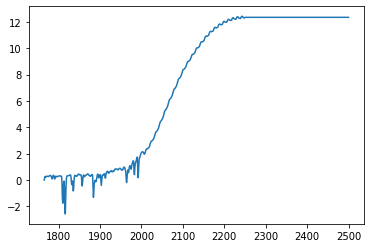

In [13]:

f85=df85['TOTAL_INCLVOLCANIC_RF']
plt.plot(f85)

In [14]:
f85.index[240]

2005

## Define functions

In [15]:
def f_a4x(x):
  fcg=np.ones(len(x))
  return fcg

In [16]:
def f_tc4(x):
  ln=len(x)-140
  if ln<0:
     ln=0
  fcg=np.hstack((np.arange(0,140)/140,np.ones([ln])))
  return fcg

In [17]:
def f_tc2(x):
  ln=len(x)-70
  if ln<0:
     ln=0
  fcg=np.hstack((np.arange(0,70)/140,np.ones([ln])/2))
  return fcg

In [18]:
def f_85(x):
  lng=np.min((len(x),len(f85)))
  fcg=np.zeros(len(x))
  fcg[:lng]=f85[:lng]
  fcg[lng:]=f85.iloc[-1]
  fcg=fcg/7.2
  return fcg

In [19]:
def linear(x, m, b):
    return m*x + b

In [20]:
def cmdl(x, prms):
   nmodes=int(len(prms)/2)
   tout=x*0
   for i in np.arange(0,nmodes):
     si=prms[i]
     ti=prms[i+nmodes]
     tout=tout+si*(1-np.exp(-x/ti))
   return tout

In [21]:
def rmdl(x, prms):
   nmodes=int(len(prms)/2)
   rout=x*0
   for i in np.arange(0,nmodes):
     si=prms[i]
     ti=prms[i+nmodes]
     rout=rout+si*(np.exp(-x/ti))
   rout=rout
   return rout

In [22]:
def cnvmdl(fcg,ntrnc,lag,*args):
  x=np.arange(0,len(fcg)+lag)
  plse=cmdl(x,args)
  dfcg=np.diff(np.hstack((0,fcg,np.repeat(fcg[-1],lag))))
  dfcg=dfcg[:ntrnc]
  convout=scipy.signal.lfilter(dfcg,1,plse)
  lagout=convout[lag:]
  return lagout

In [23]:
def cnvmdlr(fcg,ntrnc,lag,*args):
  x=np.arange(0,len(fcg)+lag)
  plse=rmdl(x,args)
  dfcg=np.diff(np.hstack((0,fcg,np.repeat(fcg[-1],lag))))
  dfcg=dfcg[:ntrnc]
  convout=scipy.signal.lfilter(dfcg,1,plse)+args[-1]
  lagout=convout[lag:]
  return lagout

In [24]:
dlag=np.repeat(0,len(mdlslr))
dlag[find(mdlslr,'GFDLCM3')[0]]=70
dlag[find(mdlslr,'ECEARTH')[0]]=240


In [25]:
flr=np.repeat(1,len(mdlslr))
flr[find(mdlslr,'ECEARTH')[0]]=500
flr[find(mdlslr,'GFDLCM3')[0]]=70
flr[find(mdlslr,'GFDLESM2M')[0]]=70
flr[find(mdlslr,'MIROC32')[0]]=140


In [26]:
flt=np.repeat(f_a4x,len(mdlslr))
flt[find(mdlslr,'ECEARTH')[0]]=f_85
flt[find(mdlslr,'GFDLCM3')[0]]=f_tc2
flt[find(mdlslr,'GFDLESM2M')[0]]=f_tc2
flt[find(mdlslr,'MIROC32')[0]]=f_tc4

In [27]:
fscn=np.repeat('ABRUPT4X',len(mdlslr))
fscn[find(mdlslr,'ECEARTH')[0]]='RCP85'
fscn[find(mdlslr,'GFDLCM3')[0]]='1pct2x'
fscn[find(mdlslr,'GFDLESM2M')[0]]='1pct2x'
fscn[find(mdlslr,'MIROC32')[0]]='1pct4x'

In [28]:
scl=np.repeat(1.0,len(mdlslr))
scl[find(mdlslr,'ECEARTH')[0]]=1/f_85(np.arange(1,1000))[-1]
scl[find(mdlslr,'GFDLCM3')[0]]=2
scl[find(mdlslr,'GFDLESM2M')[0]]=2

In [29]:
def expotas2(x, i, s1, s2, t1, t2):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,t1,t2])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,t1,t2)
  return out

In [30]:
def expotas3(x, i, s1, s2, s3, t1, t2, t3):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,s3,t1,t2,t3])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,s3,t1,t2,t3)
  return out

In [31]:
def expotas4(x, i, s1, s2, s3, s4, t1, t2, t3,t4):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,s3,s4,t1,t2,t3,t4])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,t1,t2,t3,t4)
  return out

In [32]:
def expotas5(x, i, s1, s2, s3, s4,s5, t1, t2, t3,t4,t5):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,s3,s4,s5,t1,t2,t3,t4,t5])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,s5,t1,t2,t3,t4,t5)
  return out

In [33]:
def exporad2(x, i, s1, s2, t1, t2,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,t1,t2])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,t1,t2,c)
  return out

In [34]:
def exporad3(x, i, s1, s2, s3, t1, t2, t3,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,s3,t1,t2,t3])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,s3,t1,t2,t3,c)
  return out

In [35]:
def exporad4(x, i, s1, s2, s3, s4, t1, t2, t3,t4,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,s3,s4,t1,t2,t3,t4])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,t1,t2,t3,t4,c)
  return out

In [36]:
def exporad5(x, i, s1, s2, s3, s4,s5, t1, t2, t3,t4,t5,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,s3,s4,s5,t1,t2,t3,t4,t5])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,s5,t1,t2,t3,t4,t5,c)
  return out

## Define timeseries


In [37]:
net_cnt=dslr_cnt.rsut+dslr_cnt.rlut-dslr_cnt.rsdt
net_4x=dslr_4x.rsut+dslr_4x.rlut-dslr_4x.rsdt

net_cnt_100=np.empty([len(mdlslr),1])
len4x=np.empty([len(mdlslr),1])

for i,j in enumerate(mdlslr):
  tmp=net_cnt[i,net_cnt[i,:].notnull()]
  net_cnt_100[i]=tmp[-500:].mean()
  tmp4=net_4x[i,net_4x[i,:].notnull()]
  len4x[i]=len(tmp4)
netanomlr=dslr_4x.rsut.copy(deep=True)*0
netcntlr=net_cnt.copy(deep=True)*0

for i,j in enumerate(mdlslr):
  netanomlr[i,:]=dslr_4x.rsut[i,:]+dslr_4x.rlut[i,:]-dslr_4x.rsdt[i,:]-net_cnt_100[i]
  netcntlr[i,:]=net_cnt[i,:]-net_cnt_100[i]
  

In [38]:
ts_cnt_100=np.empty([len(mdlslr),1])

#TAS anomaly
for i,j in enumerate(mdlslr):
  tmp=dslr_cnt.tas[i,dslr_cnt.tas[i,:].notnull()]
  ts_cnt_100[i]=tmp[-500:].mean()
tsanomlr=dslr_4x.tas.copy(deep=True)*0
tscntlr=dslr_cnt.tas.copy(deep=True)*0

for i,j in enumerate(mdlslr):
  tsanomlr[i,:]=dslr_4x.tas[i,:]-ts_cnt_100[i]
  tscntlr[i,:]=dslr_cnt.tas[i,:]-ts_cnt_100[i]


In [39]:
len(np.where(~np.isnan(tsanomlr[-1,:]))[0])
lents=[]
findex=[None] * 3
for j,phs in enumerate(findex0):
  findex[j]=[]
  for i,ii in enumerate(phs):
    lents.append(len(np.where(~np.isnan(tsanomlr[ii,:]))[0]))
    if lents[ii]>100:
      findex[j].append(ii)

In [40]:
findex[0].remove(find(mdlslr,'CCSM3II')[0])

#Fit timescales


Exclude one of the CCSM3 pair

In [41]:
rpts=np.hstack((findex[0],findex[1],findex[2]))

In [42]:
if 'result_lt2' not in globals():
  result_lt2=[None]*nmlr
if 'result_lr2' not in globals():
  result_lr2=[None]*nmlr
if 'result_lt3' not in globals():
  result_lt3=[None]*nmlr
if 'result_lr3' not in globals():
  result_lr3=[None]*nmlr
if 'result_lt4' not in globals():
  result_lt4=[None]*nmlr
if 'result_lr4' not in globals():
  result_lr4=[None]*nmlr
if 'result_lt5' not in globals():
  result_lt5=[None]*nmlr
if 'result_lr5' not in globals():
  result_lr5=[None]*nmlr

if 'etc_pct2' not in globals():
  etc_pct2=np.zeros((len(mdlslr),3,10000))
  eti_pct2=np.zeros((len(mdlslr),3,10000))
if 'etc_pct3' not in globals():
  etc_pct3=np.zeros((len(mdlslr),3,10000))
  eti_pct3=np.zeros((len(mdlslr),3,10000))
if 'etc_pct4' not in globals():
  etc_pct4=np.zeros((len(mdlslr),3,10000))
  eti_pct4=np.zeros((len(mdlslr),3,10000))
if 'etc_pct5' not in globals():
  etc_pct5=np.zeros((len(mdlslr),3,10000))
  eti_pct5=np.zeros((len(mdlslr),3,10000))

if 'ti_pct2' not in globals():
  t_pct2=np.zeros((len(mdlslr),3,10000))
  ti_pct2=np.zeros((len(mdlslr),3,10000))
if 'ti_pct3' not in globals():
  t_pct3=np.zeros((len(mdlslr),3,10000))
  ti_pct3=np.zeros((len(mdlslr),3,10000))
if 'ti_pct4' not in globals():
  t_pct4=np.zeros((len(mdlslr),3,10000))
  ti_pct4=np.zeros((len(mdlslr),3,10000))
if 'ti_pct5' not in globals():
  t_pct5=np.zeros((len(mdlslr),3,10000))
  ti_pct5=np.zeros((len(mdlslr),3,10000))

## Fit timeseries (2 timescales)

In [43]:
model = lmfit.Model(expotas2)
exp_tparamslr=np.zeros((nmlr,7))



#result_lt2=[None]*nmlr
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    pt = model.make_params(s1=10.,s2=10,t1=1.,t2=50.)
    pt.add_many(('i',     i,  False, None, None, None),
                ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None))
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps/3, burn=nburn/3, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt2[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt2.pickle", "wb")
  pickle.dump(result_lt2, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt2.pickle", "rb")
  result_lt2= pickle.load(file_pkl)
  file_pkl.close()

if do_pct:
  #etc_pct2=np.zeros((len(mdlslr),3,10000))
  #eti_pct2=np.zeros((len(mdlslr),3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lt2[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))

    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    etc_pct2[i,:,:]=np.percentile(tdist,[5,50,95],1)
    eti_pct2[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc2.pickle", "wb")
  pickle.dump([etc_pct2,eti_pct2], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc2.pickle", "rb")
  etc_pct2,eti_pct2= pickle.load(file_pkl)
  file_pkl.close()

In [44]:
model = lmfit.Model(exporad2)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr2=[None]*nmlr

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
#  for i, row in enumerate(findex[0]):
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    p = model.make_params(i=i, s1=10.,s2=10.,t1=1.,t2=50.,c=0.)
    p.add_many(('i',     i,  False, None, None, None),
                ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps/2, burn=nburn/2, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr2[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr2.pickle", "wb")
  pickle.dump(result_lr2, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr2.pickle", "rb")
  result_lr2= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  #t_pct2=np.zeros((nmlr,3,10000))
  #ti_pct2=np.zeros((nmlr,3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr2[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))

    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))      
    t_pct2[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct2[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct2.pickle", "wb")
  pickle.dump([t_pct2,ti_pct2], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct2.pickle", "rb")
  t_pct2,ti_pct2= pickle.load(file_pkl)
  file_pkl.close()

## Fit timeseries (4 timescales)


In [45]:
model = lmfit.Model(expotas4)
exp_tparamslr=np.zeros((nmlr,7))


#result_lt4=[None]*nmlr
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    pt = model.make_params(i=i,s1=10.,s2=10,s3=10.,s4=10,t1=1.,t2=50.,t3=200.,t4=2000.)
    pt.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   200,  True, 100, 1000,  None),
           ('t4',   1000,  True,  1000,  5000,  None))
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt4[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt4.pickle", "wb")
  pickle.dump(result_lt4, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt4.pickle", "rb")
  result_lt4= pickle.load(file_pkl)
  file_pkl.close()



if do_pct:
  #etc_pct4=np.zeros((len(mdlslr),3,10000))
  #eti_pct4=np.zeros((len(mdlslr),3,10000))

  for row,i  in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    print(i)
    result_emcee=result_lt4[i]
    tdist4=np.zeros((10000,len(result_emcee.flatchain)))
    tidist4=np.zeros((10000,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tdist4[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tidist4[:,j]=model.eval(params=p1, x=np.arange(1,10001))      
    etc_pct4[i,:,:]=np.percentile(tdist4,[5,50,95],1)
    eti_pct4[i,:,:]=np.percentile(tidist4,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc4.pickle", "wb")
  pickle.dump([etc_pct4,eti_pct4], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc4.pickle", "rb")
  etc_pct4,eti_pct4= pickle.load(file_pkl)
  file_pkl.close()

In [46]:
model = lmfit.Model(exporad4)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr4=[None]*nmlr

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
#  for i, row in enumerate(findex[0]):
    p = model.make_params(i=i,s1=10.,s2=10.,s3=10.,s4=10.,t1=1.,t2=50.,t3=500.,t4=2000.,c=0.)
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    p.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   500,  True, 100, 1000,  None),
           ('t4',   2000,  True,  1000,  5000,  None),
           ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr4[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr4.pickle", "wb")
  pickle.dump(result_lr4, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr4.pickle", "rb")
  result_lr4= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  #t_pct4=np.zeros((nmlr,3,10000))
  #ti_pct4=np.zeros((nmlr,3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr4[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))

    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct4[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct4[i,:,:]=np.percentile(tidist,[5,50,95],1)
    
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct4.pickle", "wb")
  pickle.dump([t_pct4,ti_pct4], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct4.pickle", "rb")
  t_pct4,ti_pct4= pickle.load(file_pkl)
  file_pkl.close()

## Fit timeseries (5 timescales)

In [47]:
model = lmfit.Model(expotas5)
exp_tparamslr=np.zeros((nmlr,7))


#result_lt5=[None]*nmlr
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):

    print(i)
    pt = model.make_params(i=1,s1=10.,s2=10,s3=10.,s4=10,s5=10,t1=1.,t2=50.,t3=200.,t4=2000.,t5=8000)
    pt.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('s5',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   200,  True, 100, 1000,  None),
           ('t4',   2000,  True,  1000,  5000,  None),
           ('t5',   7000  ,  True,  5000,  10000,  None))
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps*2, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt5[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt5.pickle", "wb")
  pickle.dump(result_lt5, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt5.pickle", "rb")
  result_lt5= pickle.load(file_pkl)
  file_pkl.close()



if do_pct:
  #etc_pct5=np.zeros((len(mdlslr),3,10000))
  #eti_pct5=np.zeros((len(mdlslr),3,10000))

  for row,i in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    print(i)
    result_emcee=result_lt5[i]
    tdist5=np.zeros((10000,len(result_emcee.flatchain)))
    tidist5=np.zeros((10000,len(result_emcee.flatchain)))
   
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tdist5[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tidist5[:,j]=model.eval(params=p1, x=np.arange(1,10001))      
    etc_pct5[i,:,:]=np.percentile(tdist5,[5,50,95],1)
    eti_pct5[i,:,:]=np.percentile(tidist5,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc5.pickle", "wb")
  pickle.dump([etc_pct5,eti_pct5], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc5.pickle", "rb")
  etc_pct5,eti_pct5= pickle.load(file_pkl)
  file_pkl.close()

In [48]:
model = lmfit.Model(exporad5)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr5=[None]*nmlr

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
#  for i, row in enumerate(findex[0]):
    p = model.make_params(i=i,s1=10.,s2=10.,s3=10.,s4=10.,s5=10.,t1=1.,t2=50.,t3=500.,t4=2000.,t5=5000.,c=0.)
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    p.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('s5',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   500,  True, 100, 1000,  None),
           ('t4',   2000,  True,  1000,  5000,  None),
           ('t5',   7000,  True,  5000,  10000,  None),
           ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps*2, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr5[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr5.pickle", "wb")
  pickle.dump(result_lr5, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr5.pickle", "rb")
  result_lr5= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  #t_pct5=np.zeros((nmlr,3,10000))
  #ti_pct5=np.zeros((nmlr,3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr5[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))
    
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct5[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct5[i,:,:]=np.percentile(tidist,[5,50,95],1)
    
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct5.pickle", "wb")
  pickle.dump([t_pct5,ti_pct5], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct5.pickle", "rb")
  t_pct5,ti_pct5= pickle.load(file_pkl)
  file_pkl.close()

## Fit timeseries (3 timescales)



Temperature

In [49]:
model = lmfit.Model(expotas3)
exp_tparamslr=np.zeros((nmlr,7))

#result_lt3=[None]*len(mdlslr)
et_pct=np.zeros((len(mdlslr),3,10000))
etcr_pct=np.zeros((len(mdlslr),3))
et140_pct=np.zeros((len(mdlslr),3))
etcr35_pct=np.zeros((len(mdlslr),3))
pfit=np.zeros((len(mdlslr),3,7))

if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  #for i, row in enumerate(mdlslr):
  for j,i in enumerate(rpts):
    print(i)
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    pt = model.make_params(s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.)
    pt.add_many(('i',     i,  False, None, None, None),
               ('s1',    5,  True, 0, 10,  None),
               ('s2',   5,  True,  0.,  10,  None),
               ('s3',   5,  True,  0., 10,  None),
               ('t1',   1,  True, 0, 10,  None),
               ('t2',   50,  True,  10,  100,  None),
               ('t3',  500, True, 100, 1000, None))
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt3[i]=result_emcee
    out.update(progress(i+1, nmlr))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt3.pickle", "wb")
  pickle.dump(result_lt3, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt3.pickle", "rb")
  result_lt3= pickle.load(file_pkl)
  file_pkl.close()
if do_pct:
  #etc_pct3=np.zeros((len(mdlslr),3,10000))
  #eti_pct3=np.zeros((len(mdlslr),3,10000))

  for row, i in enumerate(rpts):
    print(i)
    result_emcee=result_lt3[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))
    pdist=np.zeros((7,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      pdist[:,j]=ptmp
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p_i = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tidist[:,j]=model.eval(params=p_i, x=np.arange(1,10001))
    pfit[i,:,:]=np.percentile(pdist,[5,50,95],1)
    etc_pct3[i,:,:]=np.percentile(tdist,[5,50,95],1)
    eti_pct3[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pct3.pickle", "wb")
  pickle.dump([etc_pct3,eti_pct3], file_pkl)
  file_pkl.close()
# Getting back the objects:
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pct3.pickle", "rb")
  etc_pct3,eti_pct3 = pickle.load(file_pkl)
  file_pkl.close()

4xco2

In [50]:
model = lmfit.Model(exporad3)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr3=[None]*nmlr
#t_pct3=np.zeros((nmlr,3,10000))
#ti_pct3=np.zeros((nmlr,3,10000))

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
    pt = model.make_params(i=i,s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.,c=0)
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    pt.add_many(('i',     i,  False, None, None, None),
               ('s1',    5,  True, 0, 10,  None),
               ('s2',   5,  True,  0.,  10,  None),
               ('s3',   5,  True,  0., 10,  None),
               ('t1',   1,  True, 0, 10,  None),
               ('t2',   50,  True,  10,  100,  None),
               ('t3',  500, True, 100, 1000, None),
               ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr3[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr3.pickle", "wb")
  pickle.dump(result_lr3, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr3.pickle", "rb")
  result_lr3= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr3[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))
    
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct3[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct3[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct3.pickle", "wb")
  pickle.dump([t_pct3,ti_pct3], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct3.pickle", "rb")
  t_pct3,ti_pct3= pickle.load(file_pkl)
  file_pkl.close()

#assess timescales

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


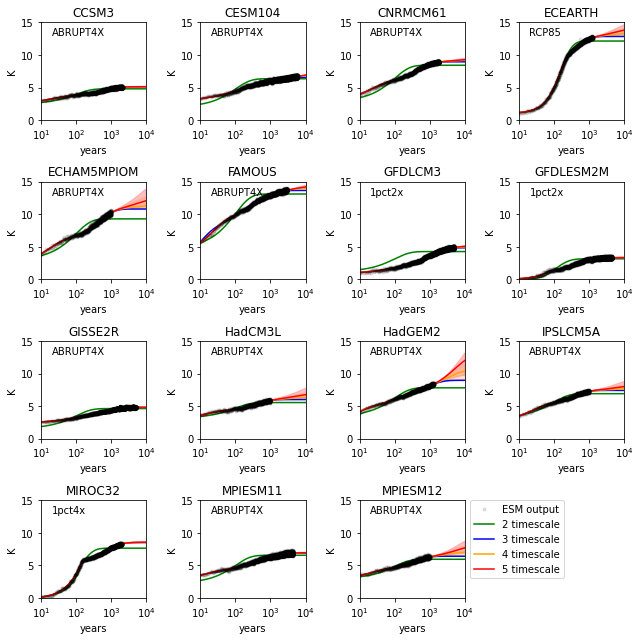

In [51]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['2','3','4','5']
fig.set_figheight(9)
fig.set_figwidth(9)

for j, i in enumerate(findex[0]):
   print(j)
   p2=axes[j].plot(eti_pct2[i,1,:],'g')
   axes[j].fill_between(np.arange(0,10000),eti_pct2[i,0,:],eti_pct2[i,2,:],color=[0.6,1,0.6],alpha=0.1)
   p3=axes[j].plot(eti_pct3[i,1,:],'b')
   axes[j].fill_between(np.arange(0,10000),eti_pct3[i,0,:],eti_pct3[i,2,:],color=[0.6,.6,0.1],alpha=0.1)

   p4=axes[j].plot(eti_pct4[i,1,:],'orange')
   axes[j].fill_between(np.arange(0,10000),eti_pct4[i,0,:],eti_pct4[i,2,:],color=[1,.8,.5],alpha=0.5)

   p5=axes[j].plot(eti_pct5[i,1,:],'r')
   axes[j].fill_between(np.arange(0,10000),eti_pct5[i,0,:],eti_pct5[i,2,:],color=[1,.5,.5],alpha=0.5)

   p1=axes[j].plot(tsanomlr[i,:],'k.',alpha=0.1)
   axes[j].set_xscale('log')
   axes[j].set_title(mdlslr[i])
   axes[j].set_ylabel('K')
   axes[j].set_xlabel('years')
   axes[j].text(20,13,fscn[i])
   axes[j].set_ylim([0,15])
   axes[j].set_xlim([10,10000])
   axes[j].set_xticks([10,100,1000,10000])


   

fig.delaxes(axes[15])

plt.tight_layout()


axes[j].legend([p1[0],p2[0],p3[0],p4[0],p5[0]],['ESM output','2 timescale','3 timescale','4 timescale','5 timescale'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_t.png", bbox_inches='tight')
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_t.pdf", bbox_inches='tight')


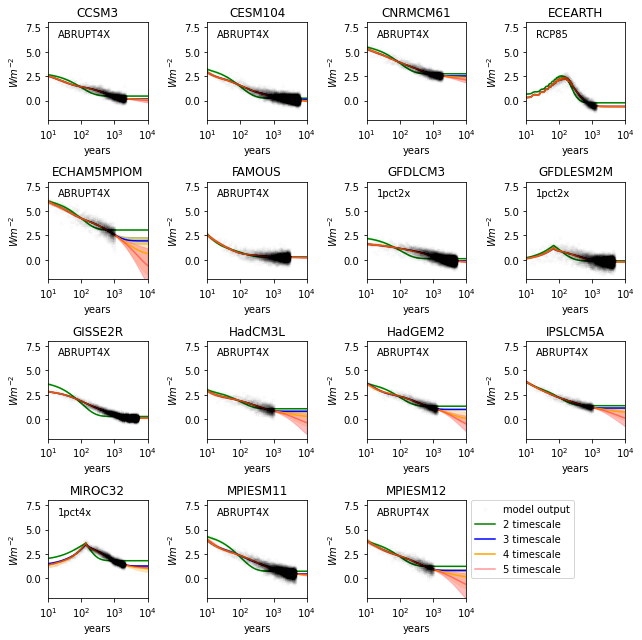

In [52]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['2','3','4','5']
fig.set_figheight(9)
fig.set_figwidth(9)

for j, i in enumerate(findex[0]):
   p2=axes[j].plot(ti_pct2[i,1,:],'g')
   axes[j].fill_between(np.arange(0,10000),ti_pct2[i,0,:],ti_pct2[i,2,:],color=[0.6,1,0.6],alpha=0.5)
   p3=axes[j].plot(ti_pct3[i,1,:],'b')
   axes[j].fill_between(np.arange(0,10000),ti_pct3[i,0,:],ti_pct3[i,2,:],color=[0.6,.6,0.1],alpha=0.5)

   p4=axes[j].plot(ti_pct4[i,1,:],'orange')
   axes[j].fill_between(np.arange(0,10000),ti_pct4[i,0,:],ti_pct4[i,2,:],color=[1,.8,.5],alpha=0.5)

   p5=axes[j].plot(ti_pct5[i,1,:],'r',alpha=0.4)
   axes[j].fill_between(np.arange(0,10000),ti_pct5[i,0,:],ti_pct5[i,2,:],color=[1,.5,.5],alpha=0.5)

   p1=axes[j].plot(-net_4x[i,:],'k.',alpha=0.01)
   axes[j].set_xscale('log')
   axes[j].set_xlim([10,10000])
   axes[j].set_ylim([-2,8])

   axes[j].set_ylabel('$Wm^{-2}$')
   axes[j].set_xlabel('years')
   axes[j].text(20,6.5,fscn[i])
   axes[j].set_xticks([10,100,1000,10000])


   axes[j].set_title(mdlslr[i])

fig.delaxes(axes[15])

plt.tight_layout()
axes[j].legend([p1[0],p2[0],p3[0],p4[0],p5[0]],['model output','2 timescale','3 timescale','4 timescale','5 timescale'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_r.png", bbox_inches='tight')
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_r.pdf", bbox_inches='tight')

In [53]:
errts=np.zeros([4,len(mdlslr)])
for i, row in enumerate(findex[0]):
  errts[0,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct2[row,1,:len(tsanomlr[row,:])]))
  errts[1,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct3[row,1,:len(tsanomlr[row,:])]))
  errts[2,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct4[row,1,:len(tsanomlr[row,:])]))
  errts[3,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct5[row,1,:len(tsanomlr[row,:])]))
  



In [54]:
errrs=np.zeros([4,len(mdlslr)])
for i, row in enumerate(findex[0]):
  errrs[0,row]=np.mean(np.square(net_4x[row,:]+ti_pct2[row,1,:len(tsanomlr[row,:])]))
  errrs[1,row]=np.mean(np.square(net_4x[row,:]+ti_pct3[row,1,:len(tsanomlr[row,:])]))
  errrs[2,row]=np.mean(np.square(net_4x[row,:]+ti_pct4[row,1,:len(tsanomlr[row,:])]))
  errrs[3,row]=np.mean(np.square(net_4x[row,:]+ti_pct5[row,1,:len(tsanomlr[row,:])]))
  


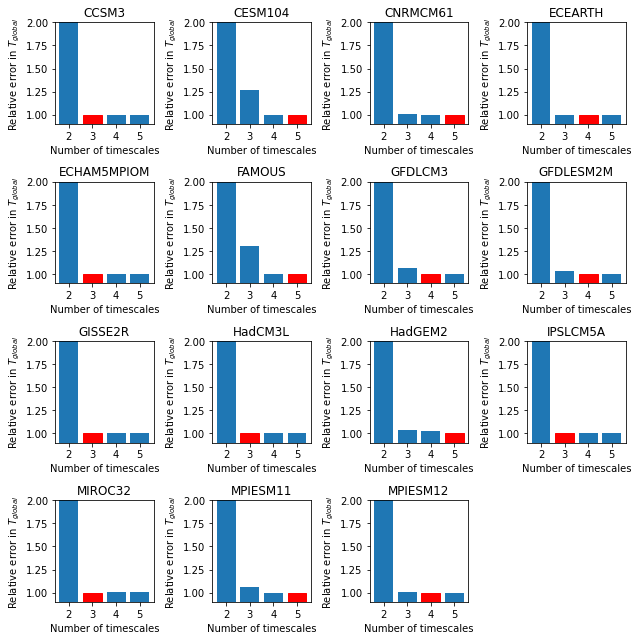

In [55]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['2','3','4','5']
fig.set_figheight(9)
fig.set_figwidth(9)
bstmod=[None]*nmlr
for j, i in enumerate(findex[0]):
   
   barlist=axes[j].bar(x=timscl,height=errts[:,i]/np.min(errts[:,i]))
   bstmod[i]=np.argmin(errts[:,i],axis=0)
   barlist[bstmod[i]].set_color('r')
   axes[j].set_title(mdlslr[i])
  # axes[j].set_yscale('log')
   axes[j].set_ylim([.9,2])
   axes[j].set_ylabel('Relative error in $T_{global}$')
   axes[j].set_xlabel('Number of timescales')


plt.tight_layout()
fig.delaxes(axes[15])


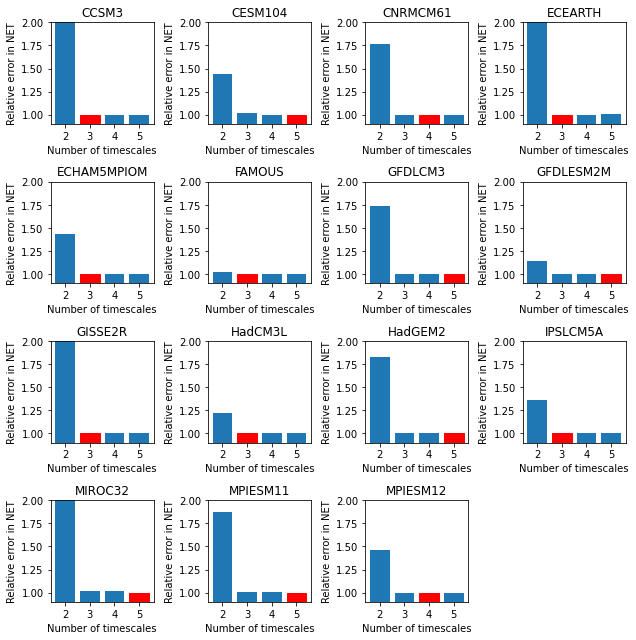

In [56]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['2','3','4','5']
fig.set_figheight(9)
fig.set_figwidth(9)
bstmod=[None]*nmlr
for j, i in enumerate(findex[0]):
   
   barlist=axes[j].bar(x=timscl,height=errrs[:,i]/np.min(errrs[:,i]))
   bstmod[i]=np.argmin(errrs[:,i],axis=0)
   barlist[bstmod[i]].set_color('r')
   axes[j].set_title(mdlslr[i])
  # axes[j].set_yscale('log')
   axes[j].set_ylim([.9,2])
   axes[j].set_ylabel('Relative error in NET')
   axes[j].set_xlabel('Number of timescales')



plt.tight_layout()
fig.delaxes(axes[15])


# Define climate sensitivities

In [57]:
et_pct=etc_pct5
eti_pct=eti_pct5

t_pct=t_pct5
ti_pct=ti_pct5

t_pct[findex[1],:,:]=t_pct4[findex[1],:,:]
t_pct[findex[2],:,:]=t_pct4[findex[2],:,:]
et_pct[findex[1],:,:]=etc_pct4[findex[1],:,:]
et_pct[findex[2],:,:]=etc_pct4[findex[2],:,:]

In [58]:
cbal_extrap=t_pct[:,1,-1]

In [59]:
gsenslr=np.zeros((nmlr,1))
gsensls=np.zeros((nmlr,1))

gsenslr_corr=np.zeros((nmlr,1))

gsenslg=np.zeros((nmlr,1))

gfcglr=np.zeros((nmlr,1))
gfcglg=np.zeros((nmlr,1))
gfcgls=np.zeros((nmlr,1))


gsenslr_end=np.zeros((nmlr,1))

tmax=np.zeros((nmlr,1))
t150=np.zeros((nmlr,1))

ttcr=np.zeros((nmlr,1))
t140=np.zeros((nmlr,1))

for i, row in enumerate(mdlslr):
  offst=cbal_extrap[i]
  x_scl=et_pct[i,1,:6000]
  y_scl=t_pct[i,1,:6000]+net_cnt_100[i]
  x_array=tsanomlr[i,:].to_numpy()*scl[i]
  y_array=-netanomlr[i,:].to_numpy()*scl[i]

  use=np.where(~numpy.isnan(x_array))
  t150[i]=x_array[140]
  x_array = x_array[use]
  y_array = y_array[use]

  x_short = x_array[use[:150]]
  y_short = y_array[use[:150]]
  isgd=np.where(~np.isnan(y_short))
  
  #calculate standard Gregory
  if np.shape(isgd)[1]>100:
    if fscn[i]=='ABRUPT4X':
        popt_linear, pcov_linear = scipy.optimize.curve_fit(linear, x_short[isgd], y_short[isgd], p0=[-1, 10])
    else:
        popt_linear, pcov_linear = scipy.optimize.curve_fit(linear, x_scl[:150], y_scl[:150], p0=[-1, 10])
    
  else:
    popt_linear=np.empty((2,1))
    popt_linear[:]=np.nan


  if -popt_linear[1]/popt_linear[0]>0:
    gsenslr[i]=-popt_linear[1]/popt_linear[0]
    gsenslr_corr[i]=-(popt_linear[1]-offst)/popt_linear[0]
    
    gfcglr[i]=popt_linear[1]
  else:
    gsenslr[i]=np.nan
    gfcglr[i]=np.nan


  #calculate LR Gregory (lat 15cpt warming)
  tmax[i]=np.nanmax(x_array)

  numts=np.min((x_array > tmax[i]*.85).nonzero()).astype(int)
  x_end=x_array[numts:use[0].shape[0]]
  y_end=y_array[numts:use[0].shape[0]]

  if len(y_array)>500:
    popt_long, pcov_long = scipy.optimize.curve_fit(linear, x_end, y_end, p0=[-1, 10])
  else:
    popt_long=np.empty((2,1))
    popt_long[:]=np.nan    

  if -popt_long[1]/popt_long[0]>0:
    gsenslg[i]=-popt_long[1]/popt_long[0]
    gfcglg[i]=popt_long[1]
  else:
    gsenslg[i]=np.nan
    gfcglg[i]=np.nan


#calculate LR method for synthetic 4xco2
  x_send=x_scl[numts:use[0].shape[0]]
  y_send=y_scl[numts:use[0].shape[0]]
  if ~np.isnan(x_send[-1]):
      popt_slong, pcov_slong = scipy.optimize.curve_fit(linear, x_send, y_send, p0=[-1, 10])
  else:
    popt_slong=np.empty((2,1))
    popt_slong[:]=np.nan

  if -popt_slong[1]/popt_slong[0]>0:
    gsensls[i]=-popt_slong[1]/popt_slong[0]
    gfcgls[i]=popt_slong[1]
  else:
    gsensls[i]=np.nan
    gfcgls[i]=np.nan

#calculate TCR
  ttmp=scipy.signal.lfilter(np.ones([150]).T/140,1,x_array)
  if len(y_array)>139:
    ttcr[i]=ttmp[69]
    t140[i]=ttmp[139]
  else:
    ttcr[i]=np.nan
    t140[i]=np.nan





/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


#plot results


##plot NET

###lrmip


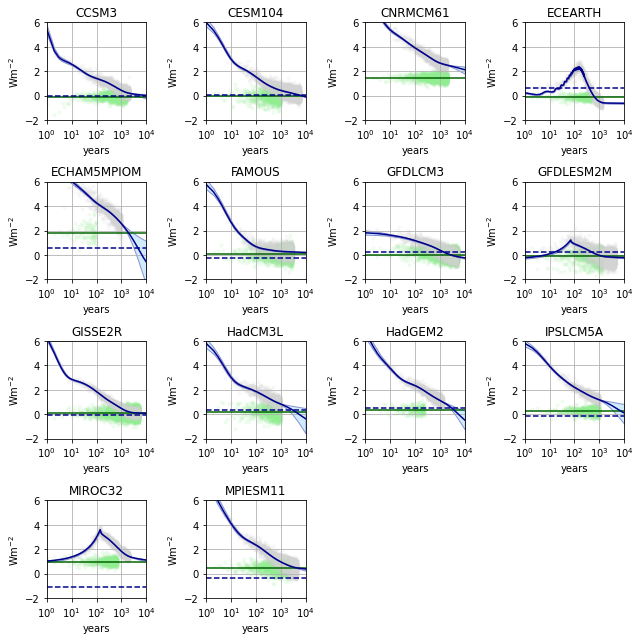

In [89]:

fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)



for j, i in enumerate(findex[0]):

  p3=axes[j].hlines(y=-net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')
  p6=axes[j].hlines(y=-ti_pct[i,1,-1], xmin=1, xmax=10001, colors='darkblue', linestyles='--')

  y_array=-net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen',alpha=.1)
  y_array=-net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),ti_pct[i,0,:],ti_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),ti_pct[i,1,:],color='darkblue')

  
axes[15].set_visible(False)
axes[14].set_visible(False)

plt.tight_layout()
axes[j].legend([p3,p6,p5[0],p4], ['$R_0^{CTRL}$','$R_{extrap}^{4x}$','ABRUPT4X (median fit)','ABRUPT4X (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_lrmip.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_lrmip.pdf", bbox_inches='tight')


###cmip5

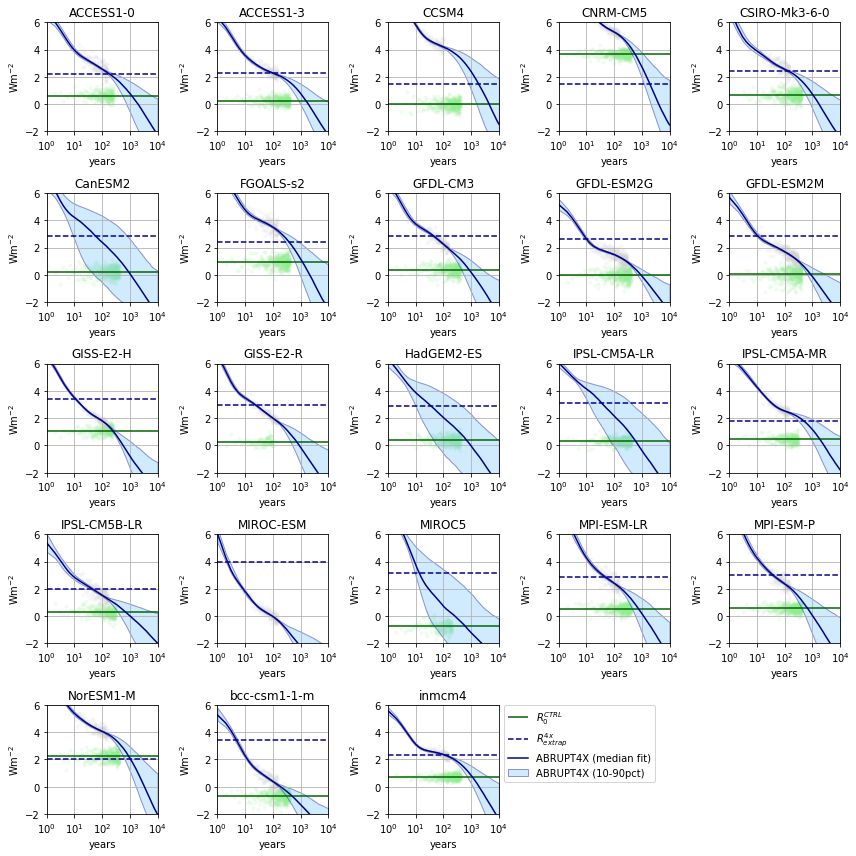

In [90]:

fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(12)
fig.set_figwidth(12)



for j, i in enumerate(findex[1]):

  p3=axes[j].hlines(y=-net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')
  p6=axes[j].hlines(y=-ti_pct[i,1,-1], xmin=1, xmax=10001, colors='darkblue', linestyles='--')

  y_array=-net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen',alpha=.1)
  y_array=-net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),ti_pct[i,0,:],ti_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),ti_pct[i,1,:],color='darkblue')

  
axes[23].set_visible(False)
axes[24].set_visible(False)
  
plt.tight_layout()
axes[j].legend([p3,p6,p5[0],p4], ['$R_0^{CTRL}$','$R_{extrap}^{4x}$','ABRUPT4X (median fit)','ABRUPT4X (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_cmip5.png", bbox_inches='tight')

###cmip6


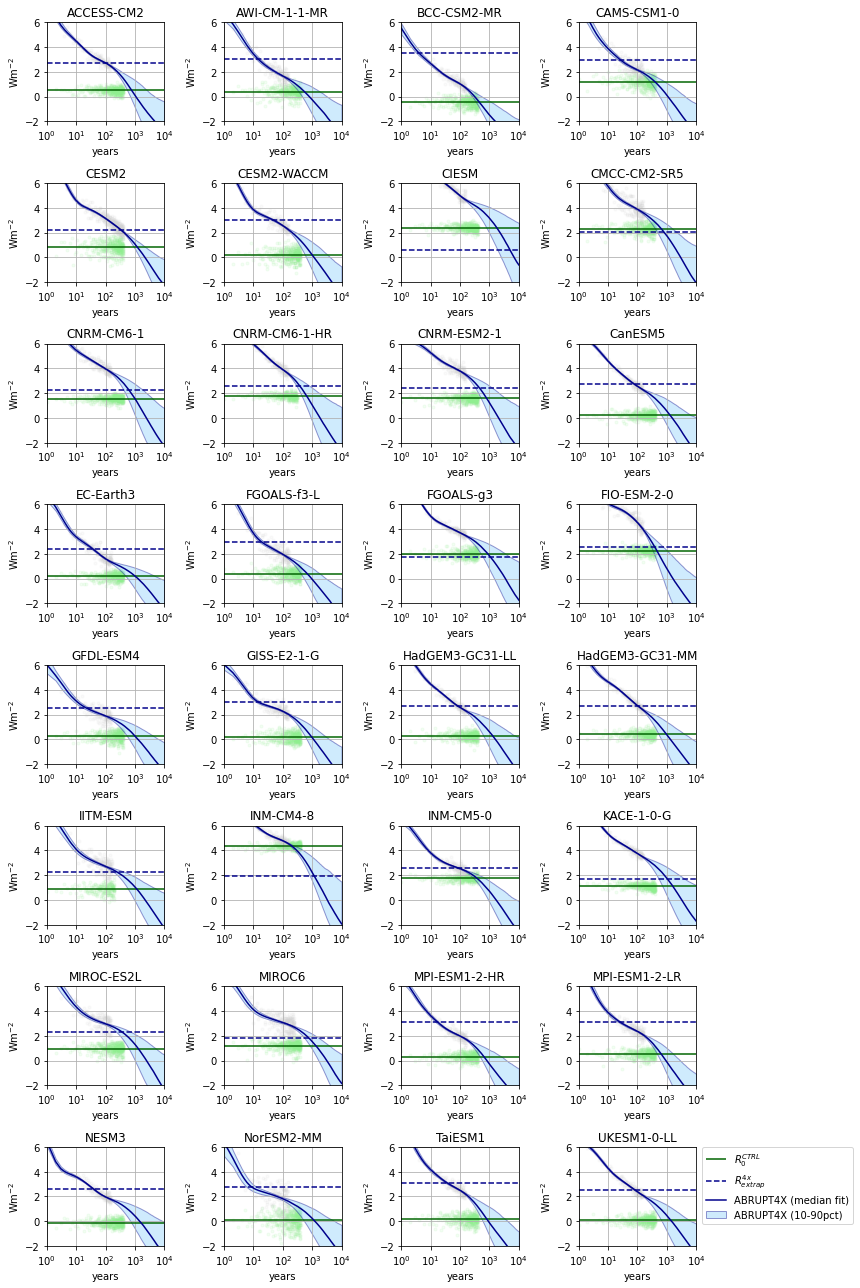

In [91]:

fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(10)



for j, i in enumerate(findex[2]):

  p3=axes[j].hlines(y=-net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')
  p6=axes[j].hlines(y=-ti_pct[i,1,-1], xmin=1, xmax=10001, colors='darkblue', linestyles='--')

  y_array=-net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen',alpha=.1)
  y_array=-net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),ti_pct[i,0,:],ti_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),ti_pct[i,1,:],color='darkblue')

  
  
plt.tight_layout()
axes[j].legend([p3,p6,p5[0],p4], ['$R_0^{CTRL}$','$R_{extrap}^{4x}$','ABRUPT4X (median fit)','ABRUPT4X (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_cmip6.png", bbox_inches='tight')

## plot TAS


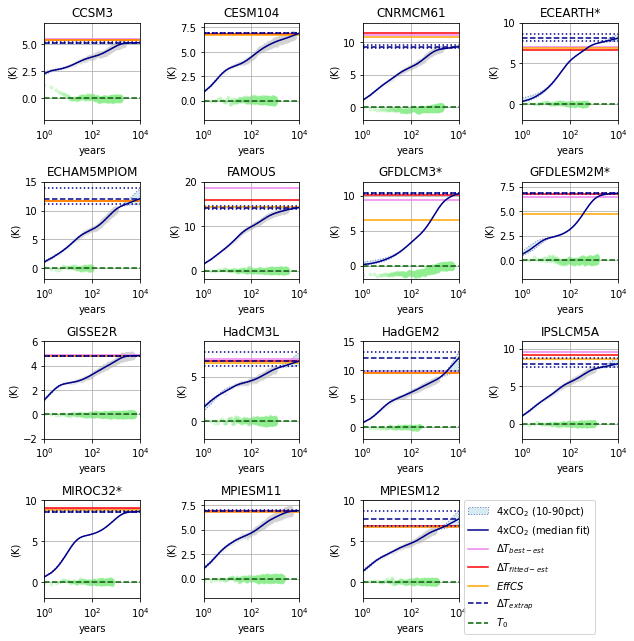

In [92]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)

for j,i in enumerate(findex[0]):
  
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  if fscn[i]=='ABRUPT4X':
    p0=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)
 

  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.3)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,2,-1]])
  if fscn[i]=='ABRUPT4X':
    axes[j].set_title(mdlslr[i])
  else:
    axes[j].set_title(mdlslr[i]+'*')

  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,np.ceil(tmx+1)])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p11=axes[j].axhline(gsensls[i],color='red')

  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].axhline(et_pct[i,0,-1],color='darkblue',linestyle=':')
  axes[j].axhline(et_pct[i,2,-1],color='darkblue',linestyle=':')

  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')
axes[15].set_visible(False)
plt.tight_layout()
axes[j].legend([p1,p5[0],p2,p11,p3,p4,pz], ['4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$\Delta T_{best-est}$','$\Delta T_{fitted-est}$','$EffCS$','$\Delta T_{extrap}$','$T_0$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_lrmip.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_lrmip.pdf", bbox_inches='tight')



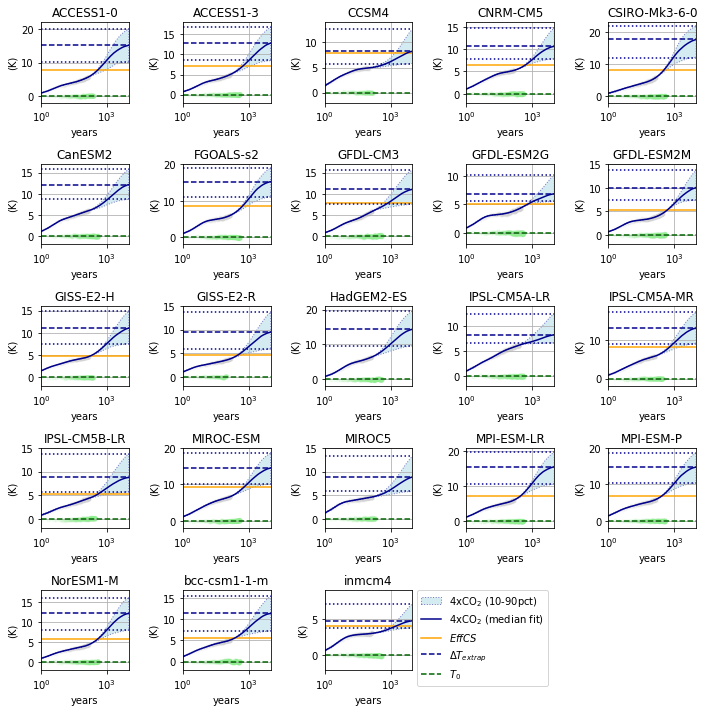

In [93]:
fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(10)
fig.set_figwidth(10)

for j,i in enumerate(findex[1]):
   
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,2,-1]])

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,np.ceil(tmx+1)])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].axhline(et_pct[i,0,-1],color='darkblue',linestyle=':')
  axes[j].axhline(et_pct[i,2,-1],color='darkblue',linestyle=':')

  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')

  
plt.tight_layout()
axes[j].legend([p1,p5[0],p3,p4,pz], ['4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$EffCS$','$\Delta T_{extrap}$','$T_0$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
axes[23].axis('off')
axes[24].axis('off')
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_cmip5.png", bbox_inches='tight', dpi=300)


In [94]:
et_pct.shape

(75, 3, 10000)

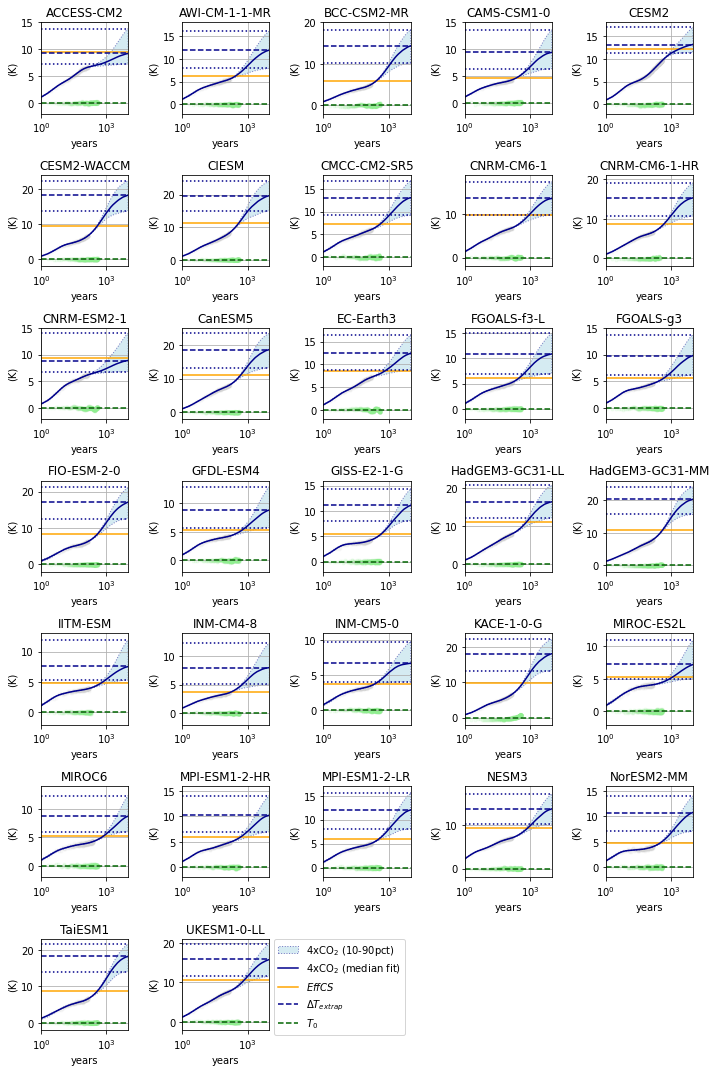

In [95]:
fig, axes = plt.subplots(ncols=5,nrows=7)
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(10)

for j,i in enumerate(findex[2]):
   
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,2,-1]])

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,np.ceil(tmx+1)])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].axhline(et_pct[i,0,-1],color='darkblue',linestyle=':')
  axes[j].axhline(et_pct[i,2,-1],color='darkblue',linestyle=':')

  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')

  

plt.tight_layout()
axes[j].legend([p1,p5[0],p3,p4,pz], ['4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$EffCS$','$\Delta T_{extrap}$','$T_0$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.delaxes(axes[32])
fig.delaxes(axes[33])
fig.delaxes(axes[34])

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_cmip6.png", bbox_inches='tight', dpi=300)


##plot Gregory

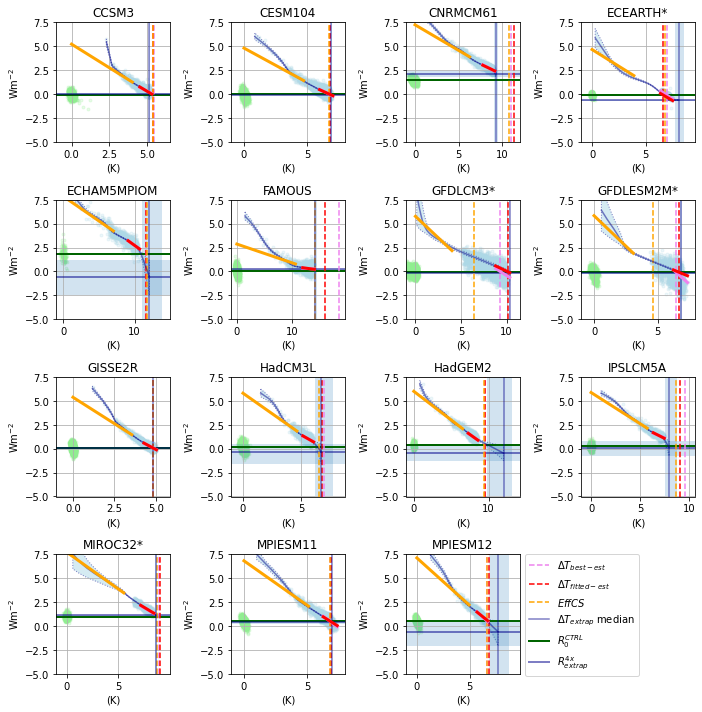

In [96]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(10)
fig.set_figwidth(10)

for i, j in enumerate(findex[0]):
  if fscn[j]=='ABRUPT4X':
    p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  else:
    p4x=axes[i].scatter(tsanomlr[j,400:]*scl[j],-net_4x[j,400:]*scl[j],marker='.',color='lightblue',alpha=0.2)

  
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)

  if fscn[j]=='ABRUPT4X':
    axes[i].set_title(mdlslr[j])
  else:
    axes[i].set_title(mdlslr[j]+'*')

  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,2,-1]])
  mnr=-5#np.floor(t_pct[j,0,-1])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([mnr,7.5])

  #axes[i].axhline(0,color='k',linestyle='-')
  p6=axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)
  p7=axes[i].axhline(t_pct[j,1,-1],color='darkblue',linestyle='-',linewidth=2,alpha=0.5)
  #axes[i].axhline(t_pct[j,0,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)
  #axes[i].axhline(t_pct[j,2,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)

  rc1=Rectangle((et_pct[j,0,-1],mnr), et_pct[j,2,-1]-et_pct[j,0,-1], 8-mnr, angle=0.0,alpha=0.2)
  rc2=Rectangle((-1,t_pct[j,0,-1]), 2+mxv, t_pct[j,2,-1]-t_pct[j,0,-1], angle=0.0,alpha=0.2)

  r1=axes[i].add_patch(rc1)
  r2=axes[i].add_patch(rc2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LS}$',linestyle='--')
  p11=axes[i].axvline(gsensls[j],color='red',label='$S_{LR}$',linestyle='--')

  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$',linestyle='--')

  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue',alpha=0.5)
  #axes[i].axvline(et_pct[j,0,-1],linestyle=':',color='darkblue',lw=1)
  #axes[i].axvline(et_pct[j,2,-1],linestyle=':',color='darkblue',lw=1)
  

  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-',alpha=.5)
  axes[i].fill_between(et_pct[j,1,:],t_pct[j,0,:],t_pct[j,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')


  axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt_100[j]),'violet',linewidth=3,linestyle='-')
  axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcgls[j]/gsensls[j],gfcgls[j]-net_cnt_100[j]),'red',linewidth=3,linestyle='-')

  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle='-')
  #axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))
  ex=(et_pct[j,2,-1]+et_pct[j,0,-1])/2
  ey=(t_pct[j,2,-1]+t_pct[j,0,-1])/2
  #ellipse = Ellipse(xy=(ex,ey), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
  #                      edgecolor='darkblue', fc='lightblue', lw=2,linestyle='-')
  
  #p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()
axes[15].set_visible(False)
axes[i].legend([p1,p11,p2,p3,p6,p7], ['$\Delta T_{best-est}$','$\Delta T_{fitted-est}$','$EffCS$','$\Delta T_{extrap}$ median','$R_0^{CTRL}$','$R_{extrap}^{4x}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_lrmip.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_lrmip.pdf", bbox_inches='tight')






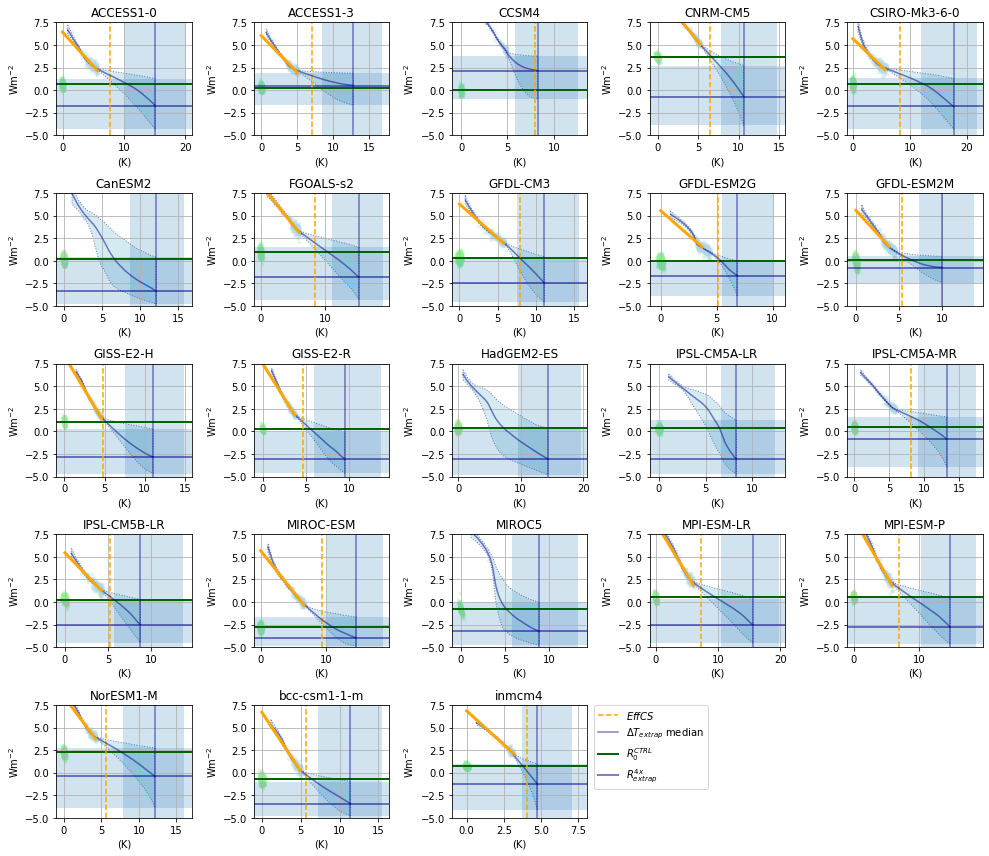

In [97]:
fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(12)
fig.set_figwidth(14)

for i, j in enumerate(findex[1]):
  if fscn[j]=='ABRUPT4X':
    p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  else:
    p4x=axes[i].scatter(tsanomlr[j,400:]*scl[j],-net_4x[j,400:]*scl[j],marker='.',color='lightblue',alpha=0.2)

  
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)

  if fscn[j]=='ABRUPT4X':
    axes[i].set_title(mdlslr[j])
  else:
    axes[i].set_title(mdlslr[j]+'*')

  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,2,-1]])
  mnr=-5#np.floor(t_pct[j,0,-1])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([mnr,7.5])

  #axes[i].axhline(0,color='k',linestyle='-')
  p6=axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)
  p7=axes[i].axhline(t_pct[j,1,-1],color='darkblue',linestyle='-',linewidth=2,alpha=0.5)
  #axes[i].axhline(t_pct[j,0,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)
  #axes[i].axhline(t_pct[j,2,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)

  rc1=Rectangle((et_pct[j,0,-1],mnr), et_pct[j,2,-1]-et_pct[j,0,-1], 8-mnr, angle=0.0,alpha=0.2)
  rc2=Rectangle((-1,t_pct[j,0,-1]), 2+mxv, t_pct[j,2,-1]-t_pct[j,0,-1], angle=0.0,alpha=0.2)

  r1=axes[i].add_patch(rc1)
  r2=axes[i].add_patch(rc2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LS}$',linestyle='--')
  #p11=axes[i].axvline(gsensls[j],color='red',label='$S_{LR}$',linestyle='--')

  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$',linestyle='--')

  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue',alpha=0.5)
  #axes[i].axvline(et_pct[j,0,-1],linestyle=':',color='darkblue',lw=1)
  #axes[i].axvline(et_pct[j,2,-1],linestyle=':',color='darkblue',lw=1)
  

  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-',alpha=.5)
  axes[i].fill_between(et_pct[j,1,:],t_pct[j,0,:],t_pct[j,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')


  axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt_100[j]),'violet',linewidth=3,linestyle='-')
  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcgls[j]/gsensls[j],gfcgls[j]-net_cnt_100[j]),'red',linewidth=3,linestyle='-')

  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle='-')
  #axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))
  ex=(et_pct[j,2,-1]+et_pct[j,0,-1])/2
  ey=(t_pct[j,2,-1]+t_pct[j,0,-1])/2
  #ellipse = Ellipse(xy=(ex,ey), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
  #                      edgecolor='darkblue', fc='lightblue', lw=2,linestyle='-')
  
  #p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()

axes[i].legend([p2,p3,p6,p7], ['$EffCS$','$\Delta T_{extrap}$ median','$R_0^{CTRL}$','$R_{extrap}^{4x}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

axes[23].axis('off')
axes[24].axis('off')

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_cmip5.png", bbox_inches='tight', dpi=300)





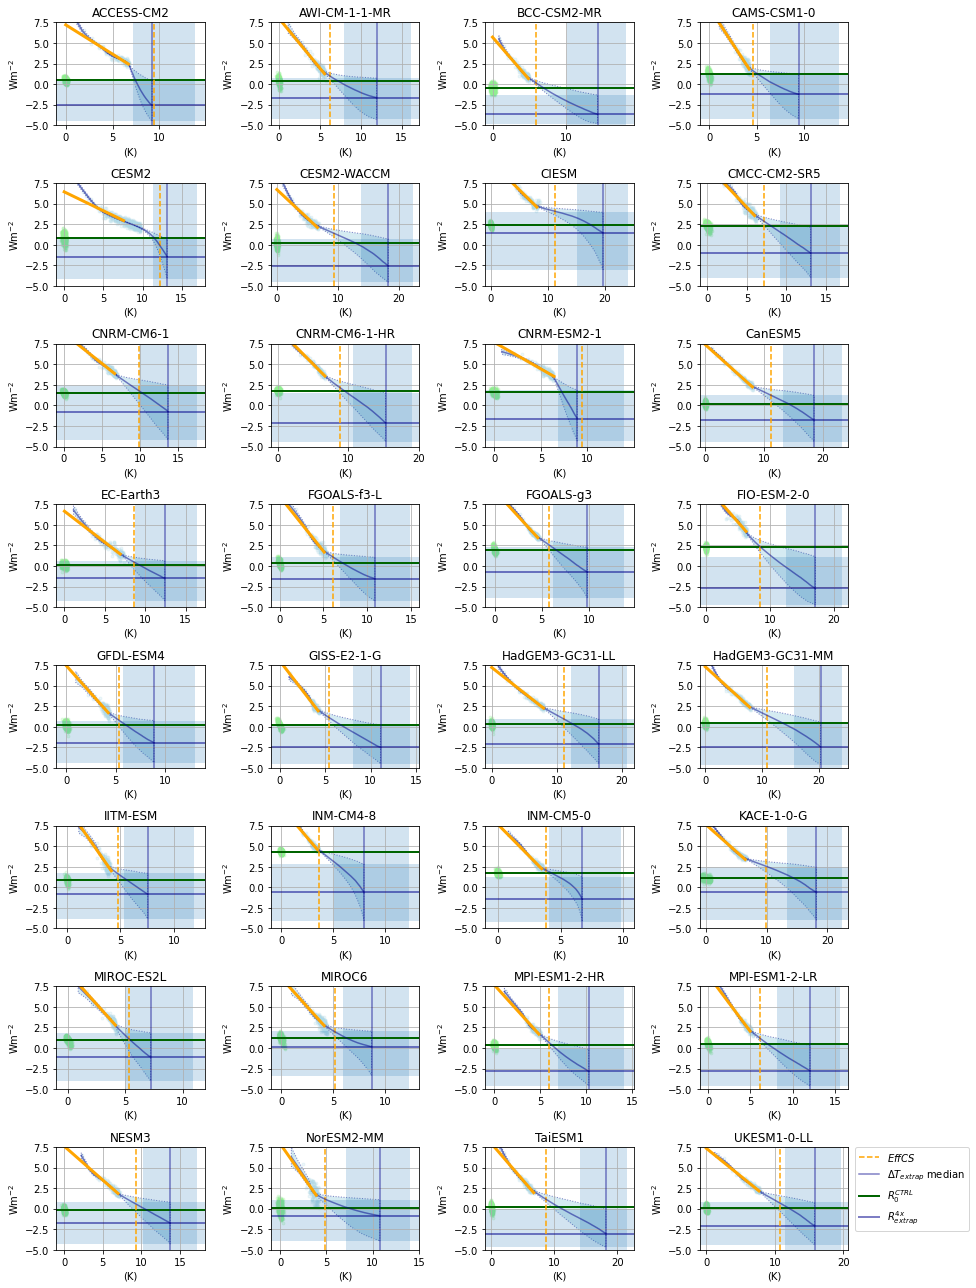

In [98]:
fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(12)

for i, j in enumerate(findex[2]):
  if fscn[j]=='ABRUPT4X':
    p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  else:
    p4x=axes[i].scatter(tsanomlr[j,400:]*scl[j],-net_4x[j,400:]*scl[j],marker='.',color='lightblue',alpha=0.2)

  
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)

  if fscn[j]=='ABRUPT4X':
    axes[i].set_title(mdlslr[j])
  else:
    axes[i].set_title(mdlslr[j]+'*')

  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,2,-1]])
  mnr=-5#np.floor(t_pct[j,0,-1])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([mnr,7.5])

  #axes[i].axhline(0,color='k',linestyle='-')
  p6=axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)
  p7=axes[i].axhline(t_pct[j,1,-1],color='darkblue',linestyle='-',linewidth=2,alpha=0.5)
  #axes[i].axhline(t_pct[j,0,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)
  #axes[i].axhline(t_pct[j,2,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)

  rc1=Rectangle((et_pct[j,0,-1],mnr), et_pct[j,2,-1]-et_pct[j,0,-1], 8-mnr, angle=0.0,alpha=0.2)
  rc2=Rectangle((-1,t_pct[j,0,-1]), 2+mxv, t_pct[j,2,-1]-t_pct[j,0,-1], angle=0.0,alpha=0.2)

  r1=axes[i].add_patch(rc1)
  r2=axes[i].add_patch(rc2)

  #p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LS}$',linestyle='--')
  #p11=axes[i].axvline(gsensls[j],color='red',label='$S_{LR}$',linestyle='--')

  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$',linestyle='--')

  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue',alpha=0.5)
  #axes[i].axvline(et_pct[j,0,-1],linestyle=':',color='darkblue',lw=1)
  #axes[i].axvline(et_pct[j,2,-1],linestyle=':',color='darkblue',lw=1)
  

  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-',alpha=.5)
  axes[i].fill_between(et_pct[j,1,:],t_pct[j,0,:],t_pct[j,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')


  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt_100[j]),'violet',linewidth=3,linestyle='-')
  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcgls[j]/gsensls[j],gfcgls[j]-net_cnt_100[j]),'red',linewidth=3,linestyle='-')

  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle='-')
  #axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))
  ex=(et_pct[j,2,-1]+et_pct[j,0,-1])/2
  ey=(t_pct[j,2,-1]+t_pct[j,0,-1])/2
  #ellipse = Ellipse(xy=(ex,ey), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
  #                      edgecolor='darkblue', fc='lightblue', lw=2,linestyle='-')
  
  #p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')


plt.tight_layout()

axes[i].legend([p2,p3,p6,p7], ['$EffCS$','$\Delta T_{extrap}$ median','$R_0^{CTRL}$','$R_{extrap}^{4x}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_cmip6.png", bbox_inches='tight', dpi=300)





##plot summary plots


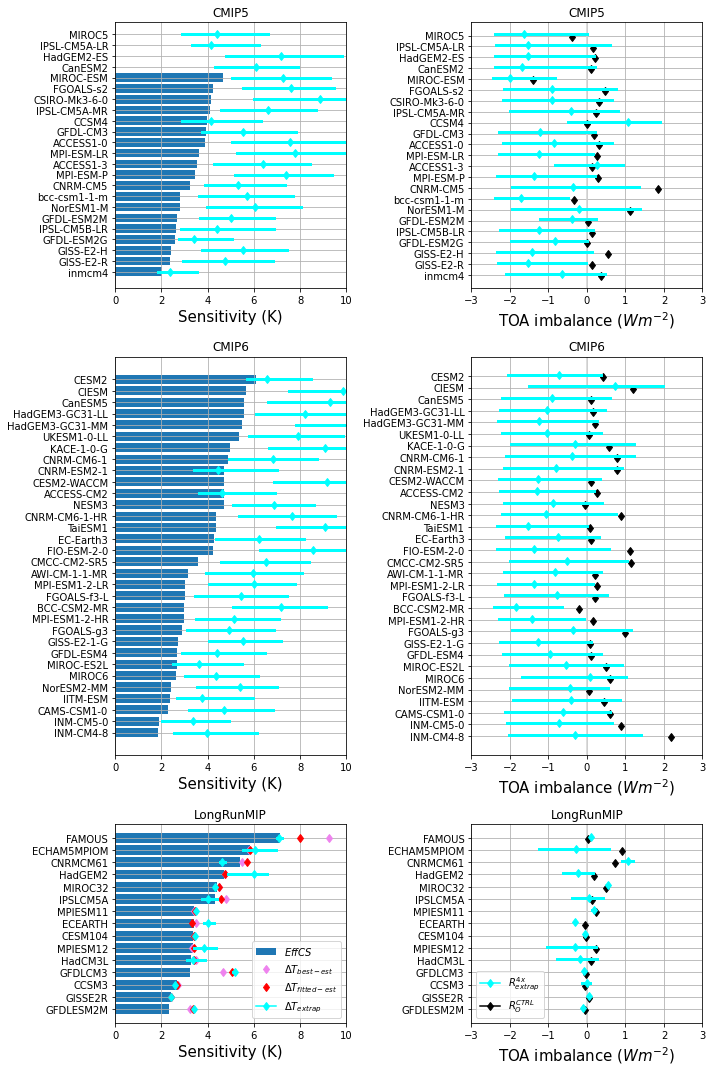

In [99]:
fig, axes = plt.subplots(ncols=2,nrows=3, gridspec_kw={'height_ratios': [2,3,1.5]})
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(10)
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "SensLG":[gsenslg[ii,0]/2 for ii in indy],
                    "SensLS":[gsensls[ii,0]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],
                    "zetaLG":[gsenslg[ii,0]/gsenslr[ii,0] for ii in indy],
                    "zeta10":[et_pct[ii,0,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta50":[et_pct[ii,1,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta90":[et_pct[ii,2,-1]/gsenslr[ii,0] for ii in indy],
                    "cbal410":[t_pct[ii,0,-1]/2 for ii in indy],
                    "cbal450":[t_pct[ii,1,-1]/2 for ii in indy],
                    "cbal490":[t_pct[ii,2,-1]/2 for ii in indy],
                    "cbal50":[-net_cnt_100[ii]/2 for ii in indy],
                    #"Sensc10":[etc_pct[ii,0,-1]/2 for ii in indy],
                    #"Sensc50":[etc_pct[ii,1,-1]/2 for ii in indy],
                    #"Sensc90":[etc_pct[ii,2,-1]/2 for ii in indy]
                     })
  df_sorted= df.sort_values('Sens')
  # bar plot with matplotlib

  plt1=axes[2*i-2].barh('Model', 'Sens',data=df_sorted)
  yp=axes[2*i-2].get_yticks()
  axes[2*i-2].set_xlabel("Sensitivity (K)", size=15)
  axes[2*i-2].set_xlim([0,10])
  pv=axes[2*i-2].plot(df_sorted.SensLG.to_numpy(),yp,'d',color='violet')
  if i==0:
    pr=axes[2*i-2].plot(df_sorted.SensLS.to_numpy(),yp,'d',color='r')

  axes[2*i-2].set_title(gens[i])
  for j,jj in enumerate(indy):
    axes[2*i-2].plot([df_sorted.Sens10.to_numpy()[j],df_sorted.Sens90.to_numpy()[j]],[yp[j],yp[j]],'cyan',linewidth=3)
    pc=axes[2*i-2].plot([df_sorted.Sens50.to_numpy()[j]],yp[j],'-',color='cyan',markerfacecolor='cyan',markeredgecolor='cyan',marker='d')
 
  axes[2*i-2].grid()
  if i==2:
    axes[2*i].legend([plt1,pv[0],pr[0],pc[0]],['$EffCS$','$\Delta T_{best-est}$','$\Delta T_{fitted-est}$','$\Delta T_{extrap}$'])
  

  plt1=axes[2*i-1].barh('Model', 'zetaLG',data=df_sorted,ec='none',fc='none')
  yp=axes[2*i-1].get_yticks()
  axes[2*i-1].set_xlabel("TOA imbalance $(Wm^{-2})$", size=15)
  axes[2*i-1].set_xlim([-3,3])
  axes[2*i-1].set_title(gens[i])
  axes[2*i-1].grid()

  axes[2*i-1].axvline(0, color='lightgrey',linestyle='-')
  for j,jj in enumerate(indy):
    #axes[3*i-1].plot([df_sorted.cbal10.to_numpy()[j],df_sorted.cbal90.to_numpy()[j]],[yp[j]-.1,yp[j]-.1],'black')
    pb=axes[2*i-1].plot([df_sorted.cbal50.to_numpy()[j]],yp[j]-.1,'black',marker='d')
    axes[2*i-1].plot([df_sorted.cbal410.to_numpy()[j],df_sorted.cbal490.to_numpy()[j]],[yp[j]+0.1,yp[j]+0.1],'cyan',linewidth=3)
    axes[2*i-1].plot([df_sorted.cbal450.to_numpy()[j]],yp[j]+0.1,'cyan',marker='d')
  if i==2:
    axes[2*i+1].legend([pc[0],pb[0]],['$R_{extrap}^{4x}$','$R_O^{CTRL}$'])
  


fig.tight_layout()
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/histo.png", bbox_inches='tight', dpi=300)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/histo.pdf", bbox_inches='tight')



##make tables

In [100]:
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "SensLG":[gsenslg[ii,0]/2 for ii in indy],
                    "SensLS":[gsensls[ii,0]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],
                    "zetaLG":[gsenslg[ii,0]/gsenslr[ii,0] for ii in indy],
                    "zeta10":[et_pct[ii,0,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta50":[et_pct[ii,1,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta90":[et_pct[ii,2,-1]/gsenslr[ii,0] for ii in indy],
                    "cbal410":[t_pct[ii,0,-1]/2 for ii in indy],
                    "cbal450":[t_pct[ii,1,-1]/2 for ii in indy],
                    "cbal490":[t_pct[ii,2,-1]/2 for ii in indy],
                    "cbal50":[-net_cnt_100[ii,0]/2 for ii in indy],
                    #"Sensc10":[etc_pct[ii,0,-1]/2 for ii in indy],
                    #"Sensc50":[etc_pct[ii,1,-1]/2 for ii in indy],
                    #"Sensc90":[etc_pct[ii,2,-1]/2 for ii in indy],
                    "len4x":[len4x[ii,0].astype(int).astype(str) for ii in indy],})
  df['srng']=df.Sens50.round(2).astype(str).str.cat(df['Sens10'].round(2).astype(str).str.cat(df['Sens90'].round(2).astype(str),sep=','),sep=' (')+')'
  df['zrng']=df.zeta50.round(2).astype(str).str.cat(df['zeta10'].round(2).astype(str).str.cat(df['zeta90'].round(2).astype(str),sep=','),sep=' (')+')'
  df['cbrng']=df.cbal450.round(2).astype(str).str.cat(df['cbal410'].round(2).astype(str).str.cat(df['cbal490'].round(2).astype(str),sep=','),sep=' (')+')'
  #df['s150rng']=df.Sensc50.round(2).astype(str).str.cat(df['Sensc10'].round(2).astype(str).str.cat(df['Sensc90'].round(2).astype(str),sep=','),sep=' (')+')'
  df2=df[['Model','len4x','Sens','SensLG','SensLS','srng','zetaLG','zrng','cbrng','cbal50']].rename(columns={'Sens': '$EffCS$', 'SensLG': '$\Delta T_{best-est}$','SensLS': '$\Delta T_{fitted-est}$', 'len4x': 'Years','srng': '$\Delta T_{extrap}','zrng': '$\zeta_{extrap}','cbrng':'$R^{4x}_{extrap}','cbal50':'$R^{CTRL}_0'})
  df2=df2.round(2)
  print(df2.to_latex(index=False, escape=False, na_rep='-'))


\begin{tabular}{llrrrlrllr}
\toprule
      Model & Years &  $EffCS$ &  $\Delta T_{best-est}$ &  $\Delta T_{fitted-est}$ & $\Delta T_{extrap} &  zetaLG &  $\zeta_{extrap} &    $R^{4x}_{extrap} &  $R^{CTRL}_0 \\
\midrule
      CCSM3 &  2120 &     2.68 &                   2.73 &                     2.69 &   2.57 (2.56,2.59) &    1.02 & 0.96 (0.96,0.97) &    0.0 (-0.12,0.07) &        -0.04 \\
    CESM104 &  5900 &     3.37 &                   3.39 &                     3.41 &   3.46 (3.44,3.48) &    1.01 & 1.03 (1.02,1.03) & -0.04 (-0.07,-0.02) &        -0.02 \\
   CNRMCM61 &  1850 &     5.42 &                   5.51 &                     5.69 &   4.64 (4.55,4.74) &    1.02 & 0.86 (0.84,0.88) &     1.06 (0.9,1.19) &         0.73 \\
    ECEARTH &  1271 &     3.42 &                   3.50 &                     3.33 &   4.03 (3.85,4.28) &    1.02 & 1.18 (1.13,1.25) & -0.31 (-0.34,-0.29) &        -0.06 \\
ECHAM5MPIOM &  1001 &     5.84 &                   5.81 &                     5.83 &   6.

In [101]:
 pmn=np.zeros((11,len(mdlslr)))
 for i,indy in enumerate(mdlslr):

    result_emcee=result_lt5[i]
    if result_emcee is not None:
      ptmp=np.zeros((11,len(result_emcee.flatchain)))
      for j in range(0,len(result_emcee.flatchain)):
        ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
      pmn[:,i]=np.mean(ptmp,1)
    else:
      pmn[:,i]=np.NaN


In [102]:
 prmn=np.zeros((12,len(mdlslr)))
 for i,indy in enumerate(mdlslr):

    result_emcee=result_lr5[i]
    if result_emcee is not None:
      ptmp=np.zeros((12,len(result_emcee.flatchain)))
      for j in range(0,len(result_emcee.flatchain)):
        ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
      prmn[:,i]=np.mean(ptmp,1)
    else:
      prmn[:,i]=np.NaN

(x, i, s1, s2, s3, s4,s5, t1, t2, t3,t4,t5,c):

In [103]:

for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens1":[pmn[0,ii] for ii in indy],
                    "Sens2":[pmn[1,ii] for ii in indy],
                    "Sens3":[pmn[2,ii] for ii in indy],
                    "Sens4":[pmn[3,ii] for ii in indy],
                    "Sens5":[pmn[4,ii] for ii in indy],
                    "Rad1":[prmn[0,ii] for ii in indy],
                    "Rad2":[prmn[1,ii] for ii in indy],
                    "Rad3":[prmn[2,ii] for ii in indy],
                    "Rad4":[prmn[3,ii] for ii in indy],
                    "Rad5":[prmn[4,ii] for ii in indy],
                    "Tau1":[prmn[5,ii] for ii in indy],
                    "Tau2":[prmn[6,ii] for ii in indy],
                    "Tau3":[prmn[7,ii] for ii in indy],
                    "Tau4":[prmn[8,ii] for ii in indy],
                    "Tau5":[prmn[9,ii] for ii in indy],
                    "Rext":[prmn[10,ii] for ii in indy],})
  df2=df[['Model','Sens1','Sens2','Sens3','Sens4','Sens5','Rad1','Rad2','Rad3','Rad4','Rad5','Tau1','Tau2','Tau3','Tau4','Tau5','Rext']].rename(columns={'Sens1': '$S_1$','Sens2': '$S_2$','Sens3': '$S_3$','Sens4': '$S_4$','Sens5': '$S_5$','Rad1': '$R_1$','Rad2': '$R_2$','Rad3': '$R_3$','Rad4': '$R_4$','Rad5': '$R_5$','Tau1': '$R\tau_1$','Tau2': '$\tau_2$','Tau3': '$\tau_3$','Tau4': '$\tau_4$','Tau5': '$\tau_5$', 'Rext': '$R^{4x}_{extrap}$'})
  df2=df2.round(2)
  print(df2.to_latex(index=False, escape=False, na_rep='-'))

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
      Model &  $S_1$ &  $S_2$ &  $S_3$ &  $S_4$ &  $S_5$ &  $R_1$ &  $R_2$ &  $R_3$ &  $R_4$ &  $R_5$ &  $R\tau_1$ &  $\tau_2$ &  $\tau_3$ &  $\tau_4$ &  $\tau_5$ &  $R^{4x}_{extrap}$ \\
\midrule
      CCSM3 &   2.48 &   1.11 &   1.49 &   0.03 &   0.04 &   8.49 &   1.50 &   1.32 &   0.16 &   0.26 &       0.96 &     22.99 &    514.18 &   2980.28 &   7585.31 &              -0.10 \\
    CESM104 &   3.18 &   1.60 &   1.16 &   0.35 &   0.88 &   4.16 &   1.23 &   0.93 &   0.29 &   0.45 &       4.76 &     80.11 &    350.89 &   3322.39 &   7609.84 &              -0.22 \\
   CNRMCM61 &   2.65 &   2.74 &   3.36 &   0.26 &   0.41 &   3.43 &   1.38 &   1.49 &   0.30 &   0.50 &       3.23 &     36.04 &    318.87 &   3118.36 &   7608.10 &               1.96 \\
    ECEARTH &   0.85 &   4.04 &   2.35 &   0.36 &   0.70 &   3.22 &   1.46 &   2.32 &   0.01 &   0.01 &       7.58 &     43.09 &    269.63 &   2612.42 &   7503.20 &              -0.63 \\
ECHAM5MPIOM 